## Proceso de Poisson no homogéneo (heterogéneo) y método de thinning

Un **proceso de Poisson no homogéneo** \( \{N(t)\}_{t \ge 0} \) tiene una
tasa (intensidad) que depende del tiempo: \( \lambda(t) \).

- \(N(t)\) cuenta cuántos eventos han ocurrido hasta el tiempo \(t\).
- Los incrementos en intervalos disjuntos siguen siendo independientes.
- Pero ahora:
  \[
  N(t+h) - N(t) \sim \text{Poisson}\left( \int_{t}^{t+h} \lambda(s)\, ds \right),
  \]
  de modo que la distribución de los incrementos depende de la forma de \(\lambda(t)\).

A nivel local, en un intervalo pequeño \([t, t + \Delta t]\):

- Probabilidad de una llegada: \( \approx \lambda(t)\, \Delta t \).
- Probabilidad de más de una llegada: \( o(\Delta t) \).

---

### Dificultad de simulación

A diferencia del caso homogéneo (tasa constante), **los tiempos entre llegadas
ya no son i.i.d. exponenciales**, por lo que no podemos simplemente generar
Exponenciales(\(\lambda\)) y sumar.

Por eso usamos el método de **thinning (adelgazamiento)**.

---

### Idea del método de thinning

1. Elegimos una **cota superior** \( \lambda_{\max} \) tal que
   \[
   \lambda(t) \le \lambda_{\max} \quad \text{para todo } t \in [0, T].
   \]
2. Simulamos un **proceso de Poisson homogéneo** con tasa \( \lambda_{\max} \)
   en el intervalo \([0, T]\). Esto nos da una secuencia de tiempos candidatos:
   \[
   S_1, S_2, \dots, S_m.
   \]
3. Para cada tiempo candidato \( S_i \):
   - Calculamos la intensidad real \( \lambda(S_i) \).
   - Aceptamos ese evento con probabilidad
     \[
     p_i = \frac{\lambda(S_i)}{\lambda_{\max}}.
     \]
   - Esto se implementa generando \( U_i \sim U(0,1) \):
     - Si \( U_i \le p_i \): **aceptamos** la llegada en \( S_i \).
     - Si \( U_i > p_i \): **rechazamos** la llegada.

4. Los tiempos aceptados son las llegadas del proceso de Poisson no homogéneo:
   \[
   0 < T_1 < T_2 < \dots < T_n \le T.
   \]

---

### Pseudocódigo del algoritmo de thinning

Supongamos que tenemos una función `lambda(t)` y una cota superior `lam_max`.

```text
Entrada: lambda(t), lam_max, horizonte T
Salida: tiempos de llegada [T1, T2, ..., Tn] del Poisson no homogéneo

1. Generar candidatos S_1, ..., S_m ~ Proceso de Poisson homogéneo con tasa lam_max en [0, T]

2. arrival_times ← [ ]  # lista de tiempos aceptados

3. Para cada candidato S_i:
       a) Calcular lam_i ← lambda(S_i)
       b) Calcular p_i ← lam_i / lam_max
       c) Generar U_i ~ Uniforme(0, 1)
       d) Si U_i ≤ p_i:
              añadir S_i a arrival_times
          en otro caso:
              rechazar S_i

4. Devolver arrival_times


\lambda

In [1]:

### 3.2 Celda 2 – Python: configurar ruta del proyecto y `sys.path`

import os
import sys

def find_repo_root(marker="src"):
    """
    Sube directorios hacia arriba desde el directorio actual hasta encontrar
    uno que contenga una carpeta llamada `marker` (por defecto 'src').
    """
    cwd = os.getcwd()
    while True:
        if marker in os.listdir(cwd):
            return cwd
        parent = os.path.dirname(cwd)
        if parent == cwd:  # hemos llegado a la raíz del sistema de archivos
            return None
        cwd = parent

repo_root = find_repo_root("src")
print("Directorio actual:", os.getcwd())
print("Raíz del repo detectada:", repo_root)

if repo_root is None:
    raise RuntimeError("No se encontró una carpeta 'src' en los directorios superiores.")

# Añadimos la raíz del repo al sys.path para poder hacer `from src...`
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

print("Primeras entradas de sys.path:")
for p in sys.path[:5]:
    print("  ", p)


Directorio actual: c:\Users\mator\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\9 Sem\Estocásticos\procesosEstocasticosTeam5\notebooks
Raíz del repo detectada: c:\Users\mator\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\9 Sem\Estocásticos\procesosEstocasticosTeam5
Primeras entradas de sys.path:
   c:\Users\mator\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\9 Sem\Estocásticos\procesosEstocasticosTeam5
   c:\Users\mator\OneDrive - INSTITUTO TECNOLOGICO AUTONOMO DE MEXICO\9 Sem\Estocásticos\procesosEstocasticosTeam5\notebooks
   c:\Users\mator\anaconda3\python311.zip
   c:\Users\mator\anaconda3\DLLs
   c:\Users\mator\anaconda3\Lib


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from src.poisson.no_homogeneo import simulate_poisson_nonhomogeneous

# Parámetros de simulación
T = 10.0  # horizonte de tiempo

# Definimos una intensidad lambda(t), por ejemplo:
# lambda(t) = 2 + 3 * sin^2(pi t / T)
def lam_t(t):
    return 2.0 + 3.0 * np.sin(np.pi * t / T) ** 2

# Cota superior: aquí es fácil, lambda(t) ∈ [2, 5]
lam_max = 5.0

rng = np.random.default_rng(seed=123)

arrival_times = simulate_poisson_nonhomogeneous(lam_t, T, lam_max, rng=rng)

print("Número de llegadas:", len(arrival_times))
print("Primeros tiempos de llegada:", arrival_times[:10])


Número de llegadas: 44
Primeros tiempos de llegada: [0.27311327 0.74343744 1.60113111 1.89685864 2.07473195 2.14768034
 2.47374582 2.56739276 2.71934722 2.88117659]


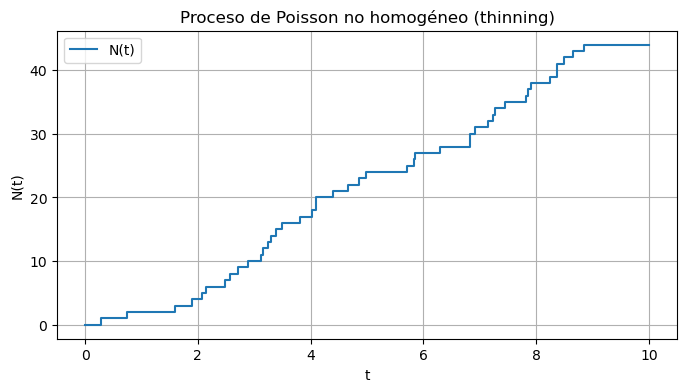

In [3]:
# Construimos el camino de N(t) como proceso escalonado

if len(arrival_times) == 0:
    print("No hubo llegadas en [0, T]")
else:
    # t_vals y N_vals para un gráfico escalonado
    t_vals = np.concatenate(([0.0], np.repeat(arrival_times, 2), [T]))
    n_events = np.arange(len(arrival_times) + 1)
    N_vals = np.repeat(n_events, 2)
    t_vals[-1] = T  # aseguramos que el último punto sea exactamente T

    plt.figure(figsize=(8, 4))
    plt.step(t_vals, N_vals, where="post", label="N(t)")
    plt.xlabel("t")
    plt.ylabel("N(t)")
    plt.title("Proceso de Poisson no homogéneo (thinning)")
    plt.grid(True)
    plt.legend()
    plt.show()


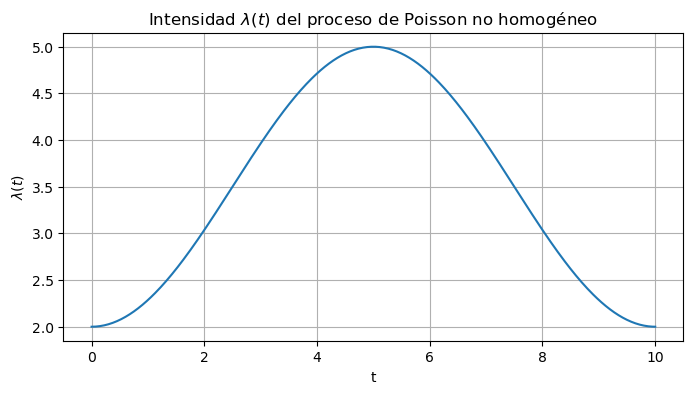

In [4]:
# Visualizamos la intensidad lambda(t) en el mismo intervalo [0, T]

t_grid = np.linspace(0, T, 400)
lam_values = lam_t(t_grid)

plt.figure(figsize=(8, 4))
plt.plot(t_grid, lam_values)
plt.xlabel("t")
plt.ylabel(r"$\lambda(t)$")
plt.title("Intensidad $\lambda(t)$ del proceso de Poisson no homogéneo")
plt.grid(True)
plt.show()
